# Example 2: Separating and clustering vocalizations

In this notebook we will

* Load vocalization intervals detected in Example 1

* Attempt a rough clustering of calls using sklearn, umap, hdbscan

* Attempt to improve upon the initial clustering by template matching (opencv)

In [11]:
import sys
sys.path.append("../src/")

In [12]:
import time

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output, Audio, display
from soundsig.sound import plot_spectrogram, spectrogram
from soundsig.signal import bandpass_filter

from audio_utils import get_amplitude_envelope
from interfaces.audio import LazyWavInterface
from plotting_utils import MultiChannelPlotter, MultiSpecPlotter

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Load the data

We will be using the same audio file used in the notebook Example 1, `example.wav`. In addition, we will load the vocalization intervals we found, saved in `example_intervals.npy`.

In [13]:
audio_signal = LazyWavInterface("example.wav", dtype=np.float64)

In [174]:
intervals = np.load("example_intervals.npy")[()]

###  Let's check a couple just to make sure they are okay.

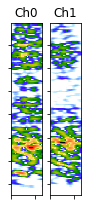

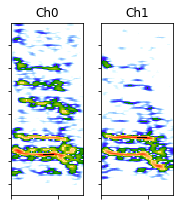

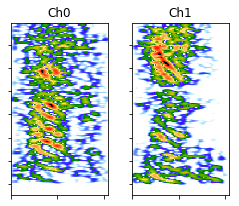

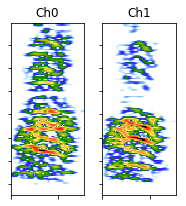

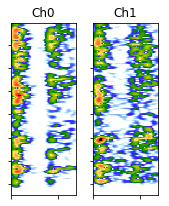

In [384]:
NUM_EXAMPLES = 5
random_indexes = np.random.choice(np.arange(len(intervals)), size=NUM_EXAMPLES, replace=False)
for randind in random_indexes:
    t1, t2 = intervals[randind]
    
    t_arr, sig = audio_signal.time_slice(t1, t2)
    sig = sig - np.mean(sig, axis=0)
    sig = bandpass_filter(sig.T, audio_signal.sampling_rate, 1000, 8000).T
    
    specs = []
    for ch in range(sig.shape[1]):
        t_spec, f_spec, spec, _ = spectrogram(
            sig[:, ch],
            audio_signal.sampling_rate,
            1000,
            50,
            min_freq=500,
            max_freq=8000,
            cmplx=False
        )
        specs.append((t_spec, f_spec, spec))
    width = (t2 - t1) * 16
    plotter = MultiSpecPlotter(
        specs,
        panel_size=(width, 3),
        layout="horizontal",
        colorbar=False,
        dBNoise=30,
    )
    for ax_idx in range(len(plotter.axes)):
        plotter.axes[ax_idx].set_title("Ch{}".format(ax_idx))
    plotter.plot()
    
    # Play the audio with a 10ms buffer on each side
    t_arr, sig = audio_signal.time_slice(t1 - 0.01, t2 + 0.01)
    sig = sig - np.mean(sig, axis=0)
    sig = bandpass_filter(sig.T, audio_signal.sampling_rate, 1000, 8000).T
    display(Audio(sig[:, 0], rate=audio_signal.sampling_rate))
    display(Audio(sig[:, 1], rate=audio_signal.sampling_rate))

## 2. Collect all the spectrograms to cluster on

Each call can be a different length. This makes it hard to cluster when you usually need data that is the same shape every time.

To find the initial embedding and do a rough clustering, we will first compute amplitude envelopes for EVERY INTERVAL, and find their "center of mass" - what time the power in that vocalization or sound is centered at.

Then we will take a 0.5s time period around the center of mass and use that as the representative datapoint for clustering.

In [458]:
centers_of_mass = []
all_call_spectrograms = []
all_calls = []

_time = time.time()

for idx, (t1, t2) in enumerate(intervals):
    print("Working on {}/{} ({:.2f}s elapsed)".format(idx + 1, len(intervals), time.time() - _time), end="\r")
    
    # Recentered signal with a small buffer of 40ms on either side
    buffer = 0.01
    t_arr, sig = audio_signal.time_slice(t1 - buffer, t2 + buffer)
    sig = sig - np.mean(sig, axis=0)
    sig = bandpass_filter(sig.T, audio_signal.sampling_rate, 1000, 8000).T
    
    amp_env = get_amplitude_envelope(sig, fs=audio_signal.sampling_rate,
                                     lowpass=8000, highpass=1000)
    
    # Compute the temporal center of mass of the signal
    center_of_mass = t1 - buffer + np.sum((t_arr * np.sum(amp_env, axis=1))) / np.sum(amp_env)
    
    # Recentered signal with a small buffer of 40ms on either side
    buffer = 0.04
    t_arr, sig = audio_signal.time_slice(center_of_mass - buffer, center_of_mass + buffer)
    sig = sig - np.mean(sig, axis=0)
    sig = bandpass_filter(sig.T, audio_signal.sampling_rate, 1000, 8000).T
    
    specs = []
    all_calls.append(sig)
    for ch in range(sig.shape[1]):
        # Sligtly lower resolution on the spectrograms can make this go faster
        # Can increase the params to 1000, 50 for a higher resolution spectrogram
        _, _, spec, _ = spectrogram(
            sig[:, ch],
            audio_signal.sampling_rate,
            1000,
            50,
            min_freq=1000,
            max_freq=8000,
            cmplx=False
        )
        specs.append(spec)
        
    all_call_spectrograms.append(np.array(specs))
    
all_call_spectrograms = np.array(all_call_spectrograms)     
all_calls = np.array(all_calls)

## 3. Try to find a good space to visualize/cluster in

My current attempt is just PCA first, then using umap to try to get it clumpy, and then assigning clusters with hdbscan. As you will see, this is pretty rough and not ideal.

In [459]:
X = all_call_spectrograms.reshape(len(all_call_spectrograms), -1)

### Projection using UMAP

First use PCA as dimesionality reduction, and then fit a umap embedding.

It is worth tweaking the parameters to adjust how clumpy the embedding is, and `fit_every_nth_point` to adjust how much of the data is used to compute the embedding.

* `n_neighbors`: smaller is more local, larger incorporates more global structure

* `min_dist`: how close points are allowed to be in the final embedding. Higher values of min_dist mean that points must be spread further apart

In [460]:
X_pca = PCA(n_components=20).fit_transform(X)

In [469]:
fit_every_nth_point = 2
trans = umap.UMAP(n_neighbors=10, repulsion_strength=100.0, min_dist=0.9).fit(X_pca[::fit_every_nth_point])
X_umap = trans.transform(X_pca)

/auto/fhome/kevin/Projects/soundsep/env/lib/python3.5/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


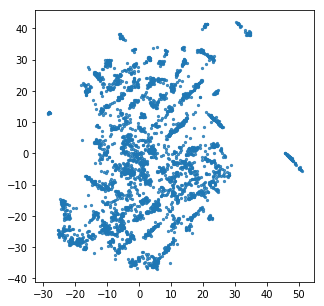

In [470]:
fig = plt.figure(figsize=(5, 5))
plt.scatter(*X_umap.T, alpha=0.8, s=5)
plt.show()
plt.close(fig)

## 4. Label points using above embedding

HDBSCAN is a density based clustering algorithm that doesn't require you to define how many clusters exist beforehand. In this situation, this will likely undercluster the data. But its a first step. 

In [471]:
labels = hdbscan.HDBSCAN().fit_predict(X_umap)

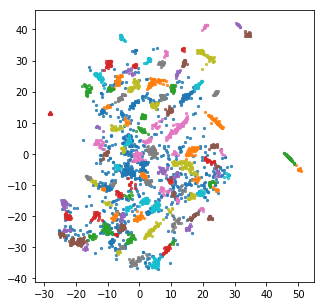

In [472]:
fig = plt.figure(figsize=(5, 5))
for l in np.unique(labels):
    plt.scatter(*X_umap[labels == l].T, alpha=0.8, s=5)
plt.show()
plt.close(fig)


### Visualize 5 of the clusters found

The cluster labeled "-1" is the cluster of spectrograms that did not make it into a proper cluster. It is clear that there are many calls that failed to get grouped up.

'Label -1 (n=571)'

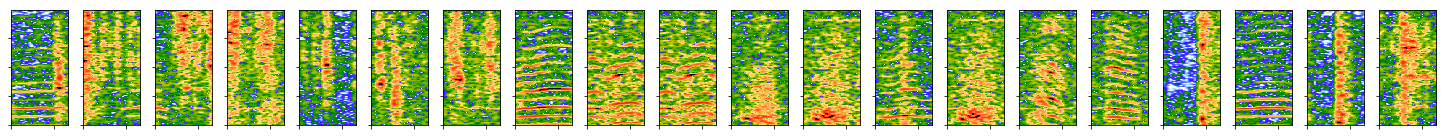

'Label 0 (n=11)'

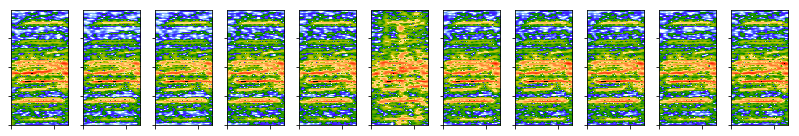

'Label 1 (n=44)'

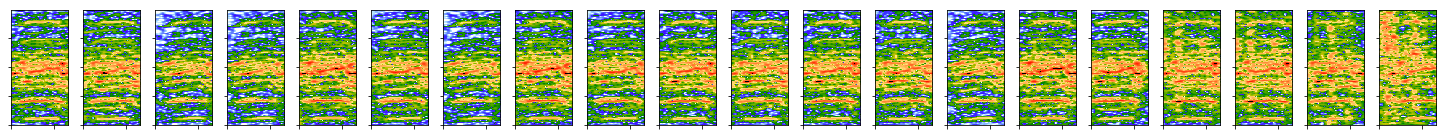

'Label 2 (n=8)'

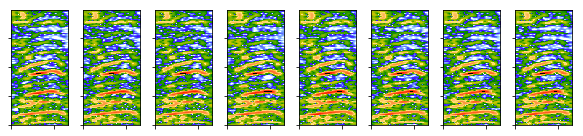

'Label 3 (n=11)'

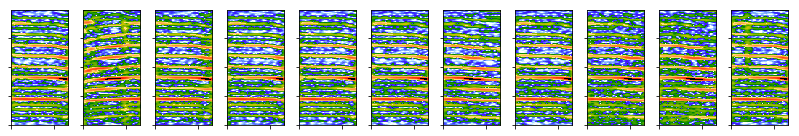

In [473]:
for l in np.unique(labels)[:5]:
    display("Label {} (n={})".format(l, int(np.sum(labels == l))))
    specs = all_call_spectrograms[labels == l][:20]
    data = [
        (
            np.arange(0, spec.shape[1]),
            np.arange(0, spec.shape[2]),
            spec[0]
        ) for spec in specs
    ]
    plotter = MultiSpecPlotter(data, panel_size=(1, 2), layout="horizontal", colorbar=False)
    plotter.plot()
    
    silence = np.zeros(shape=(int(audio_signal.sampling_rate) // 2,))
    sig = np.zeros(shape=(0,))
    for idx in range(10):
        if idx >= np.sum(labels == l):
            break
        sig = np.concatenate([sig, all_calls[labels == l][idx][:, 1], silence])
    
    display(Audio(sig, rate=audio_signal.sampling_rate))

## 5. Visualize the clusters identified

In [554]:
print(np.unique(labels, return_counts=True))

(array([ -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
        12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,
        25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
        38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
        51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,
        64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
        77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
        90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
       103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
       116, 117, 118, 119, 120]), array([571,  11,  44,   8,  11,  27,  12,  16,  58,  24,   6,  73,  39,
         7,   5,  13,  11,  18,  54,  20,  25,  53,  20,  36,  14,  20,
       100,  28,  34,  53,  20,  11,  27,  17,  13,  20,  15,  22,  27,
        37,  34,  28,  16,  23,  37,  23,   6,  32,  24,  43,   6,   8,
         8,  33,  13,  25,   

In [513]:
cluster_means = []
cluster_labels = []
for l in np.unique(labels):
    # Don't include the -1 cluster which is just all the points that didn't make it into a cluster
    if l == -1:
        continue
    specs = all_call_spectrograms[labels == l]
    cluster_means.append(np.mean(specs, axis=0))
    cluster_labels.append(l)
cluster_means = np.array(cluster_means)
cluster_labels = np.array(cluster_labels)

These are the cluster means


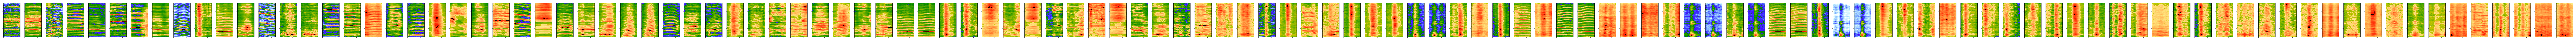

In [555]:
data_ch0 = [
    (
        np.arange(0, spec.shape[1]),
        np.arange(0, spec.shape[2]),
        spec[0]
    ) for spec in cluster_means
]
print("These are the cluster means")
plotter = MultiSpecPlotter(data_ch0, panel_size=(1, 2), layout="horizontal", colorbar=False)
plotter.plot()

These are the relative amplitudes on the two channels for the cluster means


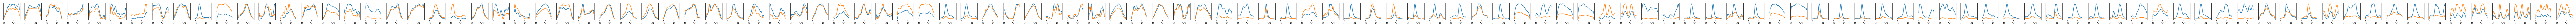

In [556]:
data_amp_env = [
    np.mean(spec, axis=1) for spec in cluster_means
]
print("These are the relative amplitudes on the two channels for the cluster means")
plotter = MultiChannelPlotter(data_amp_env, panel_size=(1, 1), layout="horizontal")
plotter.set_plot_fn(lambda x, ax: ax.plot(x.T))
plotter.map_axes(lambda ax: ax.set_yticks([]))
fig = plotter.plot()

## 6. Export spectrogram data for visualizer / manual sorting in GUI

It is clear that the automatic sorting leaves a lot to be desired. Until that can be fixed, you need to manually sort data.

I would like to make a GUI that visualizes the calls in the umap embedding and see data at a glance, allows you to select prototypical calls, label and remove cage noise, and reassign labels.

Because the spectrogram and umap embedding take the longest to compute, we'll save them to a file here. But there is no reason that these cannot be computed later on. However, the spectrogram data may take a lot of space in memory/on disk. For this reason, maybe a different strategy might be useful.

In [558]:
np.save("example_embedding.npy", X_umap)
np.save("example_spectrograms.npy", all_call_spectrograms)